# Gender Prediction based on Bag of Words and TF-IDF

Two conditions:
- each prompt is fed separately
- all prompts of a user are concatenated and then vectorized

expanded prompts without capitalization, new lines and punctuation
stopword removal cauased accuracy to drop to 40 in tf-idf and bow
Pos Label is 1

In [150]:
import sqlite3
import pandas as pd
from helpers.normalization import remove_punctuation_and_newlines, remove_capitalization

conn = sqlite3.connect('../../giicg.db')

prompts = pd.read_sql("SELECT * FROM expanded_prompts", conn)
prompts = prompts[prompts['gender'].isin(['Woman (cisgender)', 'Man (cisgender)'])].reset_index()
conn.close()
prompts

,index,message_id,conversation_id,role,message_text,conversational,code,other,gender,user_id,language
0,0,1,1,user,"parsing data from python iterator, how it coul...","parsing data from python iterator, how it coul...",,,Man (cisgender),6,en
1,1,730,32,user,Write python function to do operations with in...,Write python function to do operations with in...,,report_dt\tsource\tmetric_name\tmetric_num\tme...,Man (cisgender),6,en
2,2,1133,55,user,Write shortest tutorial on creating RAG on ema...,Write shortest tutorial on creating RAG on ema...,,,Man (cisgender),6,en
3,3,1135,55,user,what is FAISS,what is FAISS,,,Man (cisgender),6,en
4,4,1137,55,user,Transform given code to process large .mbox file,Transform given code to process large .mbox file,,Transform given code to process large .mbox file,Man (cisgender),6,en
...,...,...,...,...,...,...,...,...,...,...,...
741,748,1646,82,user,"def run_query(query, n_results):\n query_em...",this is my code. I want to: Get nodes and edge...,"def run_query(query, n_results):\n query_em...",,Man (cisgender),92,en
742,749,1845,37,user,\n nun möchte ich judgement balancing m...,Now I want to bring judgement balancing into t...,,,Woman (cisgender),29,de
743,750,1847,37,user,\n ich sehe keine veränderung im Plot. Was ...,I do not see any change in the plot.,,,Woman (cisgender),29,de
744,751,1849,2,user,\n I am working on the problem of reconstru...,\n I am working on the problem of reconstru...,,Classic CV - Drone navigation\nIf you ever tho...,Man (cisgender),8,en


## Concatenate prompts per user

In [151]:
user_prompts = (
    prompts.groupby(['user_id', 'gender'])['conversational']
    .apply(' '.join)
    .reset_index()    # Reset index to create a DataFrame
)

user_prompts.columns = ['user_id', 'gender', 'combined_prompts']

user_prompts

,user_id,gender,combined_prompts
0,6,Man (cisgender),"parsing data from python iterator, how it coul..."
1,8,Man (cisgender),\n I am working on the problem of reconstru...
2,11,Woman (cisgender),Can you adapt the following code so that inste...
3,15,Man (cisgender),SET_ALL_TABLES action is currently not fetchin...
4,16,Woman (cisgender),I want to use Dummy Hot encoding to replace th...
5,25,Man (cisgender),what is the best way to encode and compress a ...
6,28,Woman (cisgender),I have a pandas dataframe like this:\n\nI want...
7,29,Woman (cisgender),Now I want to bring judgement balancing into t...
8,31,Man (cisgender),How can I make use of an ObservableHQDatabaseC...
9,34,Man (cisgender),Blender and Python. I have a collection of hun...


## Subsample from user 73

In [152]:
def subsample(df, id):
    user_73 = df[df['user_id'] == id]
    other_users = df[df['user_id'] != id]

    user_73_sampled = user_73.sample(n=19, random_state=42)

    prompts = pd.concat([other_users, user_73_sampled], ignore_index=True)

    subsampled_messages_per_user = prompts.groupby('user_id')['message_id'].nunique().reset_index(name='num_messages')
    subsampled_with_gender = subsampled_messages_per_user.merge(
        prompts[['user_id', 'gender']].drop_duplicates(),
        on='user_id',
        how='left'
    )
    print(subsampled_with_gender.groupby(['gender']).sum())

    users_per_gender = prompts.groupby('gender')['user_id'].nunique().reset_index(name='num_users')
    print(users_per_gender)

    return prompts

prompts = subsample(prompts, 73)
# prompts = subsample(prompts, 91)
# prompts = subsample(prompts, 34)
# prompts = subsample(prompts, 79)
# prompts = subsample(prompts, 55)
# prompts = subsample(prompts, 89)
# prompts = subsample(prompts, 16)
# prompts = subsample(prompts, 28)
# prompts = subsample(prompts, 77)
# prompts = subsample(prompts, 73)
# prompts = subsample(prompts, 48)
# prompts = subsample(prompts, 83)
# prompts = subsample(prompts, 90)
# prompts = subsample(prompts, 11)
# prompts = subsample(prompts, 47)



prompts

                   user_id  num_messages
gender                                  
Man (cisgender)        780           282
Woman (cisgender)      706           254
              gender  num_users
0    Man (cisgender)         15
1  Woman (cisgender)         13


,index,message_id,conversation_id,role,message_text,conversational,code,other,gender,user_id,language
0,0,1,1,user,"parsing data from python iterator, how it coul...","parsing data from python iterator, how it coul...",,,Man (cisgender),6,en
1,1,730,32,user,Write python function to do operations with in...,Write python function to do operations with in...,,report_dt\tsource\tmetric_name\tmetric_num\tme...,Man (cisgender),6,en
2,2,1133,55,user,Write shortest tutorial on creating RAG on ema...,Write shortest tutorial on creating RAG on ema...,,,Man (cisgender),6,en
3,3,1135,55,user,what is FAISS,what is FAISS,,,Man (cisgender),6,en
4,4,1137,55,user,Transform given code to process large .mbox file,Transform given code to process large .mbox file,,Transform given code to process large .mbox file,Man (cisgender),6,en
...,...,...,...,...,...,...,...,...,...,...,...
531,501,1674,87,user,Accuracy: 1.0\n Count: 2\nMetrics for neptune...,these are the results. i to calculate a statis...,,Accuracy: 1.0\n Count: 2\nMetrics for neptune...,Woman (cisgender),73,en
532,416,1290,65,user,how are we currently processing non numerical ...,how are we currently processing non numerical ...,"def perform_optics_clustering(file_path, outpu...",,Woman (cisgender),73,en
533,425,1314,65,user,what is the reachability score,what is the reachability score,,,Woman (cisgender),73,en
534,309,372,21,user,"my features are saved in ""train_features.npy"" ...","my features are saved in ""train_features.npy"" ...",,,Woman (cisgender),73,en


## Prepare Data

In [153]:
from sklearn.base import BaseEstimator, TransformerMixin

X_user = user_prompts["combined_prompts"]
y_user = user_prompts['gender'].apply(lambda x: 1 if x == 'Woman (cisgender)' else 0)

X_prompt = prompts["conversational"]
y_prompt = prompts['gender'].apply(lambda x: 1 if x == 'Woman (cisgender)' else 0)
groups = prompts['user_id']


class Cleaner(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None): return self  # stateless
    def transform(self, X):
        def clean(text):
            text = remove_punctuation_and_newlines(text)
            text = remove_capitalization(text)
            return text
        return [clean(t) for t in X]

groups


0       6
1       6
2       6
3       6
4       6
       ..
531    73
532    73
533    73
534    73
535    73
Name: user_id, Length: 536, dtype: int64

## Prepare Pipelines

In [260]:
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, GroupKFold, cross_validate, cross_val_predict
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
import numpy as np

dummy_clf = DummyClassifier(strategy='most_frequent', random_state=42)
log_reg = LogisticRegression(C=0.005, max_iter=1000, class_weight="balanced")
svm = LinearSVC(C=0.005, max_iter=10000, class_weight="balanced")
stop_words="english"

tf_idf_vec = TfidfVectorizer(min_df=10, max_df=0.9, ngram_range=(1,1))
count_vec = CountVectorizer(min_df=10, max_df=0.9, ngram_range=(1,1))

majority_base_pipe = Pipeline([
    ("clean", Cleaner()),
    ("tfidf", tf_idf_vec),
    ("clf", dummy_clf)
])

tf_lr_pipe = Pipeline([
    ("clean", Cleaner()),
    ("tfidf", tf_idf_vec),
    ("clf", log_reg)
])

bow_lr_pipe = Pipeline([
    ("clean", Cleaner()),
    ("tfidf", count_vec),
    ("clf", log_reg)
])


tf_svm_pipe = Pipeline([
    ("clean", Cleaner()),
    ("tfidf", tf_idf_vec),
    ("clf", svm)
])

bow_svm_pipe = Pipeline([
    ("clean", Cleaner()),
    ("tfidf", count_vec),
    ("clf", svm)
])

strat_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
group_cv = GroupKFold(n_splits=5)

supports_per_fold = []

for train_idx, test_idx in strat_cv.split(X_user, y_user):
    y_test = np.array(y_user)[test_idx]
    # Count samples per class in the test (validation) fold
    unique, counts = np.unique(y_test, return_counts=True)
    support = dict(zip(unique, counts))
    supports_per_fold.append(support)

print("Supports per fold:", supports_per_fold)


scoring = ["accuracy", "precision", "precision_weighted", "recall", "recall_weighted", "f1", "f1_weighted"]


Supports per fold: [{np.int64(0): np.int64(3), np.int64(1): np.int64(3)}, {np.int64(0): np.int64(3), np.int64(1): np.int64(3)}, {np.int64(0): np.int64(3), np.int64(1): np.int64(3)}, {np.int64(0): np.int64(3), np.int64(1): np.int64(2)}, {np.int64(0): np.int64(3), np.int64(1): np.int64(2)}]


## Run Models

In [261]:

maj_base_scores = cross_validate(majority_base_pipe, X_user, y_user, cv=strat_cv, scoring=scoring, return_train_score=False, n_jobs=-1, return_estimator=True)
y_maj = cross_val_predict(majority_base_pipe, X_user, y_user, cv=strat_cv, method="predict")


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_pr

## User Level

In [262]:
from sklearn.metrics import confusion_matrix

tf_lr_scores = cross_validate(tf_lr_pipe, X_user, y_user, cv=strat_cv, scoring=scoring, return_train_score=True, n_jobs=-1, return_estimator=True)
y_tflr = cross_val_predict(tf_lr_pipe, X_user, y_user, cv=strat_cv, method="predict")


bow_lr_scores = cross_validate(bow_lr_pipe, X_user, y_user, cv=strat_cv, scoring=scoring, return_train_score=True, n_jobs=-1, return_estimator=True)
y_bowlr = cross_val_predict(bow_lr_pipe, X_user, y_user, cv=strat_cv, method="predict")
print(confusion_matrix(y_user, y_bowlr))

tf_svm_scores = cross_validate(tf_svm_pipe, X_user, y_user, cv=strat_cv, scoring=scoring, return_train_score=True, n_jobs=-1, return_estimator=True)
y_tfsvm = cross_val_predict(tf_svm_pipe, X_user, y_user, cv=strat_cv, method="predict")

bow_svm_scores = cross_validate(bow_svm_pipe, X_user, y_user, cv=strat_cv, scoring=scoring, return_train_score=True, n_jobs=-1, return_estimator=True)
y_bowsvm = cross_val_predict(bow_svm_pipe, X_user, y_user, cv=strat_cv, method="predict")

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

[[13  2]
 [ 6  7]]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


## Prompt level

In [210]:
prompt_tf_lr_scores = cross_validate(tf_lr_pipe, X_prompt, y_prompt, cv=group_cv, scoring=scoring, return_train_score=False, n_jobs=-1, return_estimator=True, groups=groups)

prompt_bow_lr_scores = cross_validate(bow_lr_pipe, X_prompt, y_prompt, cv=group_cv, scoring=scoring, return_train_score=False, n_jobs=-1, return_estimator=True, groups=groups)

prompt_tf_svm_scores = cross_validate(tf_svm_pipe, X_prompt, y_prompt, cv=group_cv, scoring=scoring, return_train_score=False, n_jobs=-1, return_estimator=True, groups=groups)

prompt_bow_svm_scores = cross_validate(bow_svm_pipe, X_prompt, y_prompt, cv=group_cv, scoring=scoring, return_train_score=False, n_jobs=-1, return_estimator=True, groups=groups)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{

In [264]:
def average_fold_weights(estimators):
    """
    Aligns terms across folds (vocabularies may differ) and returns
    a single averaged weight series for the positive class direction.
    """
    frames = []
    for est in estimators:
        vec = next(step for step in est.named_steps.values()
                   if hasattr(step, "get_feature_names_out"))
        clf = next(step for step in est.named_steps.values()
                   if hasattr(step, "coef_"))
        feats = vec.get_feature_names_out()
        coefs = clf.coef_
        if coefs.ndim == 1 or coefs.shape[0] == 1:
            w = coefs.ravel()
        else:
            # choose the row for class 1 in multiclass
            w = coefs[1]
        frames.append(pd.Series(w, index=feats, dtype=float))
    # Outer join, fill missing with 0 (feature absent in a fold treated as weight 0)
    mat = pd.concat(frames, axis=1).fillna(0.0)
    return mat.mean(axis=1).sort_values(ascending=False)

def assemble_words_lists(df):
    avg_weights = average_fold_weights(df["estimator"])
    top_pos_avg = avg_weights.head(10).reset_index()
    top_neg_avg = avg_weights.tail(10).reset_index().sort_values(by=0, ascending=True).reset_index(drop=True)
    return pd.concat([top_pos_avg, top_neg_avg], axis=1).round(3)

tf_lr_combined = assemble_words_lists(tf_lr_scores)
bow_lr_combined = assemble_words_lists(bow_lr_scores)
tf_svm_combined = assemble_words_lists(tf_svm_scores)
bow_svm_combined = assemble_words_lists(bow_svm_scores)

prompts_tf_lr_combined = assemble_words_lists(prompt_tf_lr_scores)
prompts_bow_lr_combined = assemble_words_lists(prompt_bow_lr_scores)
prompts_tf_svm_combined = assemble_words_lists(prompt_tf_svm_scores)
prompts_bow_svm_combined = assemble_words_lists(prompt_bow_svm_scores)



# Step 3: Now write to LaTeX
bow_svm_combined.to_latex("predictive_words_svm.tex", index=False, float_format="%.3f")
bow_svm_combined



,index,0,index,0
0,you,0.056,is,-0.044
1,can,0.043,if,-0.040
2,want,0.041,from,-0.038
3,me,0.039,an,-0.033
4,new,0.027,that,-0.029
5,no,0.026,on,-0.026
6,so,0.025,of,-0.024
7,same,0.023,not,-0.022
8,this,0.021,at,-0.021
9,how,0.019,but,-0.021


In [265]:
import numpy as np
import pandas as pd
def assemble_cv_metrics(results):
    metrics = [
        'accuracy', 'precision', 'precision_weighted', 'recall', 'recall_weighted',
        'f1', 'f1_weighted'
    ]

    rows = []
    for label, scores in results:
        row = {'model_vectorizer': label}
        for metric in metrics:
            # Test metric
            test_vals = scores.get(f'test_{metric}', None)
            if test_vals is not None:
                row[metric] = np.mean(test_vals)
                row[f'{metric}_std'] = np.std(test_vals)
            else:
                row[metric] = np.nan
                row[f'{metric}_std'] = np.nan

            # Train metric (if present)
            train_vals = scores.get(f'train_{metric}', None)
            if train_vals is not None:
                row[f"train_{metric}"] = np.mean(train_vals)
                row[f"train_{metric}_std"] = np.std(train_vals)
            else:
                row[f"train_{metric}"] = np.nan
                row[f"train_{metric}_std"] = np.nan

        rows.append(row)

    # Interleave mean and std columns for test, then train columns (for clarity)
    col_order = ['model_vectorizer']
    for metric in metrics:
        col_order.append(metric)
        col_order.append(f"{metric}_std")
        col_order.append(f"train_{metric}")
        col_order.append(f"train_{metric}_std")

    df = pd.DataFrame(rows, columns=col_order)
    # Round only floats/ints; keep model_vectorizer as string
    for col in col_order:
        if col != "model_vectorizer":
            df[col] = df[col].round(2)
    return df

In [266]:
results = [
    ("Majority", maj_base_scores),
    ("LR+TFIDF", tf_lr_scores),
    ("LR+BoW", bow_lr_scores),
    ("SVM+TFIDF", tf_svm_scores),
    ("SVM+BoW", bow_svm_scores),
    ("LR+TFIDF prompts", prompt_tf_lr_scores),
    ("LR+BoW prompts", prompt_bow_lr_scores),
    ("VM+TFIDF prompts", prompt_tf_svm_scores),
    ("SVM+BoW prompts", prompt_bow_svm_scores),
]
metrics_df = assemble_cv_metrics(results)
metrics_df


,model_vectorizer,accuracy,accuracy_std,train_accuracy,train_accuracy_std,precision,precision_std,train_precision,train_precision_std,precision_weighted,...,train_recall_weighted,train_recall_weighted_std,f1,f1_std,train_f1,train_f1_std,f1_weighted,f1_weighted_std,train_f1_weighted,train_f1_weighted_std
0,Majority,0.54,0.05,NaN,NaN,0.00,0.00,NaN,NaN,0.29,...,NaN,NaN,0.00,0.00,NaN,NaN,0.38,0.06,NaN,NaN
1,LR+TFIDF,0.72,0.23,0.93,0.05,0.60,0.37,0.91,0.06,0.62,...,0.93,0.05,0.61,0.38,0.92,0.06,0.65,0.29,0.93,0.05
2,LR+BoW,0.73,0.20,0.86,0.03,0.80,0.24,0.95,0.06,0.74,...,0.86,0.03,0.65,0.23,0.83,0.04,0.72,0.20,0.85,0.03
3,SVM+TFIDF,0.79,0.21,0.86,0.08,0.65,0.37,0.80,0.13,0.70,...,0.86,0.08,0.70,0.37,0.86,0.07,0.72,0.28,0.85,0.08
4,SVM+BoW,0.75,0.21,1.00,0.00,0.62,0.37,1.00,0.00,0.73,...,1.00,0.00,0.63,0.38,1.00,0.00,0.71,0.24,1.00,0.00
5,LR+TFIDF prompts,0.52,0.07,NaN,NaN,0.51,0.39,NaN,NaN,0.85,...,NaN,NaN,0.42,0.26,NaN,NaN,0.62,0.04,NaN,NaN
6,LR+BoW prompts,0.52,0.10,NaN,NaN,0.49,0.39,NaN,NaN,0.83,...,NaN,NaN,0.46,0.30,NaN,NaN,0.61,0.10,NaN,NaN
7,VM+TFIDF prompts,0.54,0.07,NaN,NaN,0.51,0.39,NaN,NaN,0.85,...,NaN,NaN,0.42,0.26,NaN,NaN,0.63,0.07,NaN,NaN
8,SVM+BoW prompts,0.53,0.05,NaN,NaN,0.51,0.39,NaN,NaN,0.85,...,NaN,NaN,0.42,0.25,NaN,NaN,0.63,0.02,NaN,NaN


## To latex

In [270]:
import pandas as pd

def create_cv_metrics_latex_tables(metrics_df: pd.DataFrame, metrics_filename: str, stds_filename: str,
                                   train_metrics_filename: str = "train_" + "cv_metrics_table.tex",
                                   train_stds_filename: str = "train_" + "cv_metrics_stds_table.tex"):

    def fmt(a, b):
        return f"{a:.2f} / {b:.2f}"

    metrics = metrics_df.copy()

    # Validation metrics table
    metrics_table = pd.DataFrame({
        'model_vectorizer': metrics['model_vectorizer'],
        'accuracy': metrics['accuracy'].map('{:.2f}'.format),
        'precision / weighted': [
            fmt(a, b)
            for a, b in zip(metrics['precision'], metrics['precision_weighted'])
        ],
        'recall / weighted': [
            fmt(a, b)
            for a, b in zip(metrics['recall'], metrics['recall_weighted'])
        ],
        'f1 / weighted': [
            fmt(a, b)
            for a, b in zip(metrics['f1'], metrics['f1_weighted'])
        ],
    })
    metrics_table.to_latex(metrics_filename, index=False, column_format='lccccc', escape=False)

    # Validation stds table
    stds_table = pd.DataFrame({
        'model_vectorizer': metrics['model_vectorizer'],
        'accuracy_std': metrics['accuracy_std'].map('{:.2f}'.format),
        'precision_std / weighted': [
            fmt(a, b)
            for a, b in zip(metrics['precision_std'], metrics['precision_weighted_std'])
        ],
        'recall_std / weighted': [
            fmt(a, b)
            for a, b in zip(metrics['recall_std'], metrics['recall_weighted_std'])
        ],
        'f1_std / weighted': [
            fmt(a, b)
            for a, b in zip(metrics['f1_std'], metrics['f1_weighted_std'])
        ],
    })
    stds_table.to_latex(stds_filename, index=False, column_format='lccccc', escape=False)

    # Train metrics table
    train_metrics_table = pd.DataFrame({
        'model_vectorizer': metrics['model_vectorizer'],
        'train_accuracy': metrics['train_accuracy'].map('{:.2f}'.format),
        'train_precision / weighted': [
            fmt(a, b)
            for a, b in zip(metrics['train_precision'], metrics['train_precision_weighted'])
        ],
        'train_recall / weighted': [
            fmt(a, b)
            for a, b in zip(metrics['train_recall'], metrics['train_recall_weighted'])
        ],
        'train_f1 / weighted': [
            fmt(a, b)
            for a, b in zip(metrics['train_f1'], metrics['train_f1_weighted'])
        ],
    })
    train_metrics_table.to_latex(train_metrics_filename, index=False, column_format='lccccc', escape=False)

    # Train stds table
    train_stds_table = pd.DataFrame({
        'model_vectorizer': metrics['model_vectorizer'],
        'train_accuracy_std': metrics['train_accuracy_std'].map('{:.2f}'.format),
        'train_precision_std / weighted': [
            fmt(a, b)
            for a, b in zip(metrics['train_precision_std'], metrics['train_precision_weighted_std'])
        ],
        'train_recall_std / weighted': [
            fmt(a, b)
            for a, b in zip(metrics['train_recall_std'], metrics['train_recall_weighted_std'])
        ],
        'train_f1_std / weighted': [
            fmt(a, b)
            for a, b in zip(metrics['train_f1_std'], metrics['train_f1_weighted_std'])
        ],
    })
    train_stds_table.to_latex(train_stds_filename, index=False, column_format='lccccc', escape=False)

In [271]:
create_cv_metrics_latex_tables(metrics_df, "cv_metrics_table.tex", "cv_metrics_stds_table.tex")

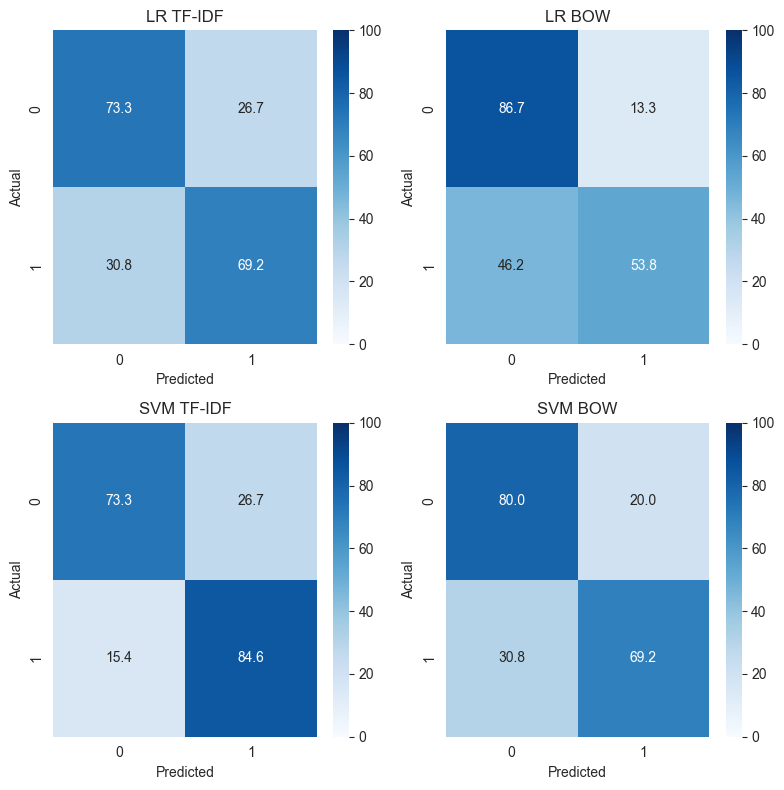

In [272]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

models = [
    ('LR TF-IDF', y_user, y_tflr),
    ('LR BOW', y_user, y_bowlr),
    ('SVM TF-IDF', y_user, y_tfsvm),
    ('SVM BOW', y_user, y_bowsvm),
]

fig, axes = plt.subplots(2, 2, figsize=(8, 8))  # 2 rows, 2 columns
axes = axes.flatten()  # flatten to easily iterate

for ax, (name, y_true, y_pred) in zip(axes, models):
    cm = confusion_matrix(y_true, y_pred)
    cm_percent = cm.astype('float') / cm.sum(axis=1, keepdims=True) * 100
    sns.heatmap(
        cm_percent, annot=True, fmt='.1f', cmap='Blues',
        ax=ax, vmin=0, vmax=100
    )
    ax.set_title(name)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

plt.tight_layout()
plt.show()

Total users (after filtering): 28
mean message count: 10.5


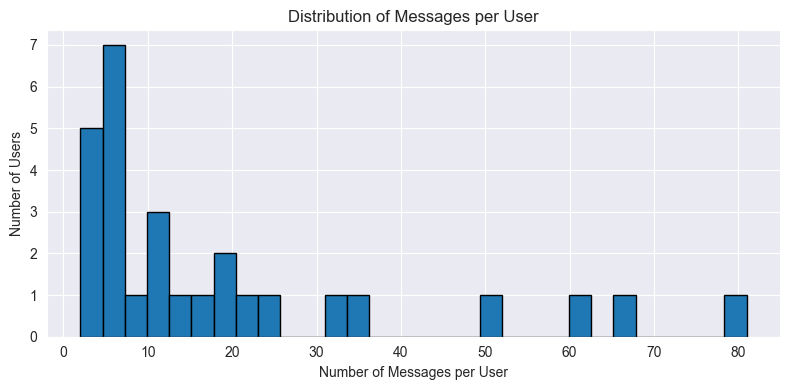

,user_id,message_count
0,91,81
1,34,66
2,79,61
3,47,51
4,55,36
5,89,31
6,16,25
7,28,22
8,77,20
9,73,19


In [164]:
messages_per_user = (
    prompts['user_id']
    .value_counts()
    .rename('message_count')
    .rename_axis('user_id')
    .reset_index()
    .sort_values('message_count', ascending=False)
)

print(f"Total users (after filtering): {len(messages_per_user)}")
print(f"mean message count: {messages_per_user['message_count'].median()}")
 # top 10 users by message count

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.hist(messages_per_user['message_count'], bins=30, edgecolor='black')
plt.xlabel('Number of Messages per User')
plt.ylabel('Number of Users')
plt.title('Distribution of Messages per User')
plt.tight_layout()
plt.show()

messages_per_user


